In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv(r'/Users/andrewssf/Documents/VDJ_Analysis/data/S10_filtered_contig_annotations.csv')

In [4]:
# basic info#
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8220 entries, 0 to 8219
Data columns (total 18 columns):
barcode             8220 non-null object
is_cell             8220 non-null bool
contig_id           8220 non-null object
high_confidence     8220 non-null bool
length              8220 non-null int64
chain               8220 non-null object
v_gene              8220 non-null object
d_gene              8220 non-null object
j_gene              8220 non-null object
c_gene              8220 non-null object
full_length         8220 non-null bool
productive          8220 non-null object
cdr3                8220 non-null object
cdr3_nt             8220 non-null object
reads               8220 non-null int64
umis                8220 non-null int64
raw_clonotype_id    8220 non-null object
raw_consensus_id    8220 non-null object
dtypes: bool(3), int64(3), object(12)
memory usage: 987.4+ KB


In [5]:
#change none to nan and check how many null bojects and where#
df.replace('None', np.nan, inplace=True)
#to count number of NaN in columns#
len(df) - df.count()

barcode                0
is_cell                0
contig_id              0
high_confidence        0
length                 0
chain                  6
v_gene              1470
d_gene              5051
j_gene              1016
c_gene                26
full_length            0
productive          1886
cdr3                1826
cdr3_nt             1826
reads                  0
umis                   0
raw_clonotype_id       2
raw_consensus_id    1906
dtype: int64

In [7]:
import sys
sys.path.insert(0, 'Users/andrewssf/Documents/VDJ_Analysis/modules')
from modules import clearnulls

df_cdr3null = clearnulls.clearnulls(df, 'cdr3')

In [31]:
#to check if cdr3 null is gone#
len(df_cdr3null.cdr3) == df_cdr3null['cdr3'].count()

True

In [8]:
#to check if cdr3 null is gone#
assert len(df_cdr3null.cdr3) == df_cdr3null['cdr3'].count()

In [11]:
#to drop cells with unproductive chains#
nonproductive = df_cdr3null[df_cdr3null['productive'] == 'FALSE'].index
df_prod = df_cdr3null.drop(nonproductive)
df_prod.shape

(6378, 18)

In [12]:
#to drop cells with duplicate chains#
df_no_dupl = df_prod.drop_duplicates(['barcode', 'chain'])
df_no_dupl.shape

(6187, 18)

In [13]:
#check which chains are listed#
df_no_dupl.chain.value_counts()

IGH      2981
IGL      1706
IGK      1484
Multi      16
Name: chain, dtype: int64

In [14]:
#limit list to only IGH, IGK, IGL#
good_list = ['IGH', 'IGK', 'IGL']
df_good = df_no_dupl[df_no_dupl['chain'].isin(good_list)].copy()
df_good.chain.value_counts()

IGH    2981
IGL    1706
IGK    1484
Name: chain, dtype: int64

In [15]:
#make sure only have cells with HC listed#
df_wHC = df_good.groupby('barcode').filter(lambda x: any(x.chain == "IGH")).copy()
df_wHC.chain.value_counts()

IGH    2981
IGL    1660
IGK    1432
Name: chain, dtype: int64

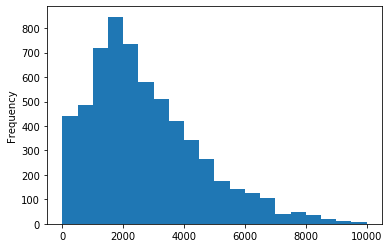

In [17]:
import matplotlib.pyplot as plt
df_wHC['umis'].plot('hist', bins=20, range=(1,10000))

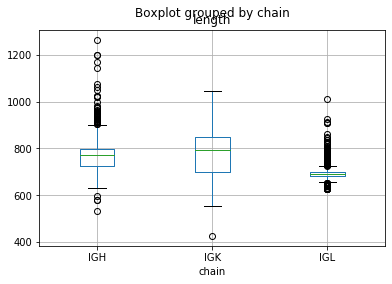

In [18]:
#visiually inspect sequence length to check quality#
df_wHC.boxplot(column='length', by='chain')

In [30]:
# to add column with CDR3 length#
df_wHC['cdr3_length'] = df_wHC['cdr3'].str.len()
df_wHC.columns

Index(['barcode', 'is_cell', 'contig_id', 'high_confidence', 'length', 'chain',
       'v_gene', 'd_gene', 'j_gene', 'c_gene', 'full_length', 'productive',
       'cdr3', 'cdr3_nt', 'reads', 'umis', 'raw_clonotype_id',
       'raw_consensus_id', 'cdr3_length'],
      dtype='object')

In [20]:
#to filter on pairs#
df_pair = df_wHC.groupby('barcode').filter(lambda x: x['chain'].count()<3)
df_pair.chain.value_counts()

IGH    2870
IGL    1549
IGK    1321
Name: chain, dtype: int64

In [21]:
#to count v_gene d_gene j_gene c_gene usage concat into one file for output#
df_vgene = df_pair.groupby('chain')['v_gene'].value_counts()
df_dgene = df_pair.groupby('chain')['d_gene'].value_counts()
df_jgene = df_pair.groupby('chain')['j_gene'].value_counts()
df_cgene = df_pair.groupby('chain')['c_gene'].value_counts()
df_gene = pd.concat([df_vgene, df_dgene, df_jgene, df_cgene], axis=0)
df_gene.head()

chain  v_gene    
IGH    IGHV1-69-2    1813
       IGHV3-11       772
       IGHV4-4         68
       IGHV3-48        50
       IGHV4-39        49
dtype: int64

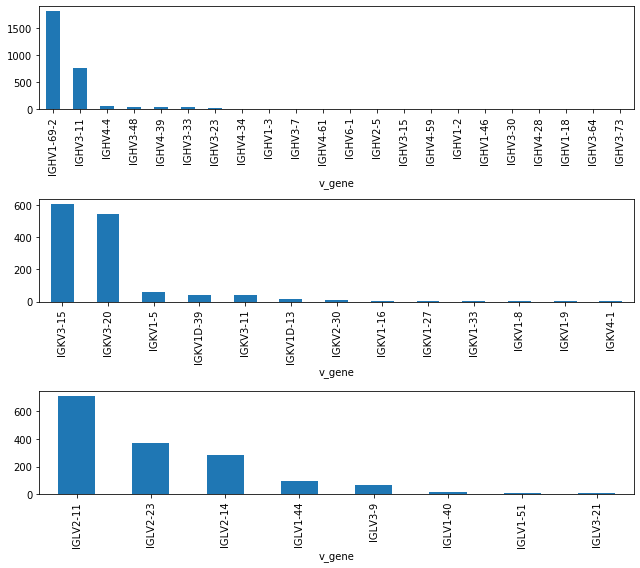

In [22]:
#visual of vgene usage#
f, a = plt.subplots(3,1)
df_vgene.xs('IGH').plot(kind='bar', ax=a[0])
df_vgene.xs('IGK').plot(kind='bar', ax=a[1])
df_vgene.xs('IGL').plot(kind='bar', ax=a[2])
plt.tight_layout(rect=[0,0,1.5,2])

In [23]:
#to export out gene usage#
import time
t = time.localtime()
timestamp = time.strftime('%m%d_%H%M', t)
df_gene.to_csv(r'/Users/andrewssf/Documents/VDJ_Analysis/results/S10genes_' + timestamp + '.csv', header = ('count'))

In [24]:
# to make multi-idexes#
df_MultiI = df_wHC.set_index(['barcode', 'chain']).sort_index()
df_MultiI.head()

is_cell                    contig_id  \
barcode            chain                                         
AAACCTGAGAATAGGG-1 IGH       True  AAACCTGAGAATAGGG-1_contig_3   
                   IGL       True  AAACCTGAGAATAGGG-1_contig_1   
AAACCTGAGCCCTAAT-1 IGH       True  AAACCTGAGCCCTAAT-1_contig_7   
                   IGK       True  AAACCTGAGCCCTAAT-1_contig_9   
                   IGL       True  AAACCTGAGCCCTAAT-1_contig_1   

                          high_confidence  length    v_gene        d_gene  \
barcode            chain                                                    
AAACCTGAGAATAGGG-1 IGH               True     816  IGHV3-11       IGHD3-3   
                   IGL               True     694  IGLV2-11           NaN   
AAACCTGAGCCCTAAT-1 IGH               True     671  IGHV3-11  IGHD3OR15-3A   
                   IGK               True     848  IGKV3-20           NaN   
                   IGL               True     663  IGLV2-11           NaN   

                         j_gene c_gene  full_length productive  \
barcode            chain                                         
AAACCTGAGAATAGGG-1 IGH    IGHJ2  IGHG1         True       TRUE   
                   IGL    IGLJ2  IGLC2         True       TRUE   
AAACCTGAGCCCTAAT-1 IGH    IGHJ2  IGHA1         True       TRUE   
                   IGK    IGKJ2   IGKC         True       TRUE   
                   IGL    IGLJ2  IGLC2         True       TRUE   

                                        cdr3  \
barcode            chain                       
AAACCTGAGAATAGGG-1 IGH    CARGATIFGVVMWHFDLW   
                   IGL          CFSYAGSNNVIF   
AAACCTGAGCCCTAAT-1 IGH    CVRGATIFGLVKWHFDLW   
                   IGK            CQHYGNSLHF   
                   IGL          CFSYAGNNNVIF   

                                                                    cdr3_nt  \
barcode            chain                                                      
AAACCTGAGAATAGGG-1 IGH    TGTGCGAGAGGGGCTACGATTTTTGGAGTGGTTATGTGGCACTTCG...   
                   IGL                 TGCTTCTCATATGCAGGCAGCAACAATGTGATATTC   
AAACCTGAGCCCTAAT-1 IGH    TGTGTGCGAGGGGCAACGATCTTTGGCCTAGTTAAGTGGCACTTCG...   
                   IGK                       TGTCAGCACTACGGTAACTCACTTCACTTT   
                   IGL                 TGCTTCTCATATGCAGGCAACAACAATGTGATATTC   

                          reads  umis raw_clonotype_id  \
barcode            chain                                 
AAACCTGAGAATAGGG-1 IGH     8202  1997      clonotype18   
                   IGL    11700  3239      clonotype18   
AAACCTGAGCCCTAAT-1 IGH      995   152     clonotype187   
                   IGK     7163  1099     clonotype187   
                   IGL     1642   425     clonotype187   

                                  raw_consensus_id  cdr3_length  
barcode            chain                                         
AAACCTGAGAATAGGG-1 IGH     clonotype18_consensus_2           18  
                   IGL     clonotype18_consensus_1           12  
AAACCTGAGCCCTAAT-1 IGH    clonotype187_consensus_5           18  
                   IGK    clonotype187_consensus_2           10  
                   IGL    clonotype187_consensus_3           12

In [25]:
#to unstack, so all chains on same barcode#
df_bybarcode = df_MultiI.unstack(level='chain')
df_bybarcode.head()

is_cell                                contig_id  \
chain                  IGH   IGK   IGL                          IGH   
barcode                                                               
AAACCTGAGAATAGGG-1    True   NaN  True  AAACCTGAGAATAGGG-1_contig_3   
AAACCTGAGCCCTAAT-1    True  True  True  AAACCTGAGCCCTAAT-1_contig_7   
AAACCTGAGCTGTTCA-1    True   NaN  True  AAACCTGAGCTGTTCA-1_contig_3   
AAACCTGAGTAGTGCG-1    True  True   NaN  AAACCTGAGTAGTGCG-1_contig_2   
AAACCTGAGTGGGCTA-1    True   NaN  True  AAACCTGAGTGGGCTA-1_contig_3   

                                                                              \
chain                                       IGK                          IGL   
barcode                                                                        
AAACCTGAGAATAGGG-1                          NaN  AAACCTGAGAATAGGG-1_contig_1   
AAACCTGAGCCCTAAT-1  AAACCTGAGCCCTAAT-1_contig_9  AAACCTGAGCCCTAAT-1_contig_1   
AAACCTGAGCTGTTCA-1                          NaN  AAACCTGAGCTGTTCA-1_contig_1   
AAACCTGAGTAGTGCG-1  AAACCTGAGTAGTGCG-1_contig_1                          NaN   
AAACCTGAGTGGGCTA-1                          NaN  AAACCTGAGTGGGCTA-1_contig_2   

                   high_confidence             length  ...    umis  \
chain                          IGH   IGK   IGL    IGH  ...     IGL   
barcode                                                ...           
AAACCTGAGAATAGGG-1            True   NaN  True  816.0  ...  3239.0   
AAACCTGAGCCCTAAT-1            True  True  True  671.0  ...   425.0   
AAACCTGAGCTGTTCA-1            True   NaN  True  768.0  ...  5183.0   
AAACCTGAGTAGTGCG-1            True  True   NaN  769.0  ...     NaN   
AAACCTGAGTGGGCTA-1            True   NaN  True  812.0  ...  2517.0   

                   raw_clonotype_id                              \
chain                           IGH           IGK           IGL   
barcode                                                           
AAACCTGAGAATAGGG-1      clonotype18           NaN   clonotype18   
AAACCTGAGCCCTAAT-1     clonotype187  clonotype187  clonotype187   
AAACCTGAGCTGTTCA-1      clonotype53           NaN   clonotype53   
AAACCTGAGTAGTGCG-1     clonotype134  clonotype134           NaN   
AAACCTGAGTGGGCTA-1       clonotype1           NaN    clonotype1   

                            raw_consensus_id                            \
chain                                    IGH                       IGK   
barcode                                                                  
AAACCTGAGAATAGGG-1   clonotype18_consensus_2                       NaN   
AAACCTGAGCCCTAAT-1  clonotype187_consensus_5  clonotype187_consensus_2   
AAACCTGAGCTGTTCA-1   clonotype53_consensus_2                       NaN   
AAACCTGAGTAGTGCG-1  clonotype134_consensus_2  clonotype134_consensus_1   
AAACCTGAGTGGGCTA-1    clonotype1_consensus_1                       NaN   

                                             cdr3_length              
chain                                    IGL         IGH   IGK   IGL  
barcode                                                               
AAACCTGAGAATAGGG-1   clonotype18_consensus_1        18.0   NaN  12.0  
AAACCTGAGCCCTAAT-1  clonotype187_consensus_3        18.0  10.0  12.0  
AAACCTGAGCTGTTCA-1   clonotype53_consensus_1        16.0   NaN  10.0  
AAACCTGAGTAGTGCG-1                       NaN        15.0  10.0   NaN  
AAACCTGAGTGGGCTA-1    clonotype1_consensus_2        18.0   NaN  12.0  

[5 rows x 51 columns]

In [26]:
df_bybarcode.columns

MultiIndex(levels=[['is_cell', 'contig_id', 'high_confidence', 'length', 'v_gene', 'd_gene', 'j_gene', 'c_gene', 'full_length', 'productive', 'cdr3', 'cdr3_nt', 'reads', 'umis', 'raw_clonotype_id', 'raw_consensus_id', 'cdr3_length'], ['IGH', 'IGK', 'IGL']],
           codes=[[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16], [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2]],
           names=[None, 'chain'])

In [27]:
#to swap and sort column levels#
df_unstack = df_MultiI.unstack(level='chain')
df_swap = df_unstack.swaplevel(axis=1)
df_sw_sort = df_swap.sort_index(axis=1, level=0)
df_sw_sort.columns

MultiIndex(levels=[['IGH', 'IGK', 'IGL'], ['c_gene', 'cdr3', 'cdr3_length', 'cdr3_nt', 'contig_id', 'd_gene', 'full_length', 'high_confidence', 'is_cell', 'j_gene', 'length', 'productive', 'raw_clonotype_id', 'raw_consensus_id', 'reads', 'umis', 'v_gene']],
           codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]],
           names=['chain', None])

In [28]:
#to slice on columns want, remove empty columns, and sort by clonotype#
df_smaller = df_bybarcode.loc[:, ['v_gene', 'd_gene', 'j_gene', 'c_gene', 'cdr3', 'cdr3_nt', 'umis', 'raw_clonotype_id', 'cdr3_length']]
df_sorted = df_smaller.sort_values(by=[('raw_clonotype_id','IGH')])
df_sm = df_sorted.dropna(axis=1, how='all')
df_sm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2981 entries, GTGCAGCGTAAGGATT-1 to TTTGTCAAGAGGGCTT-1
Data columns (total 25 columns):
(v_gene, IGH)              2981 non-null object
(v_gene, IGK)              1432 non-null object
(v_gene, IGL)              1660 non-null object
(d_gene, IGH)              2967 non-null object
(j_gene, IGH)              2972 non-null object
(j_gene, IGK)              1432 non-null object
(j_gene, IGL)              1660 non-null object
(c_gene, IGH)              2981 non-null object
(c_gene, IGK)              1431 non-null object
(c_gene, IGL)              1660 non-null object
(cdr3, IGH)                2981 non-null object
(cdr3, IGK)                1432 non-null object
(cdr3, IGL)                1660 non-null object
(cdr3_nt, IGH)             2981 non-null object
(cdr3_nt, IGK)             1432 non-null object
(cdr3_nt, IGL)             1660 non-null object
(umis, IGH)                2981 non-null float64
(umis, IGK)                1432 non-null float64
(

In [29]:
#export csv file with filtered and sorted values#
df_sm.to_csv(r'/Users/andrewssf/Documents/VDJ_Analysis/results/S10_data_' + timestamp + '.csv')